<a href="https://colab.research.google.com/github/bfdefraga/projetos-portfolio-/blob/main/Projeto_Pipeline_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PIPELINE DE DADOS NATIVOS NA NUVEM**

# 1.Contextualização

O projeto exposto detalha um Pipeline de Dados na Nuvem que utiliza mensagens geradas em um grupo no **Telegram** e as envia de forma automática para a **Plataforma AWS**. Assim, essas mensagens são extraídas e processadas para realizar as análises dos dados pertinentes às perguntas de negócio. A fim de elucidar melhor a idealização desse pipeline, alguns conceitos são abordados brevemente seguidos do relato de todos os recursos e etapas necessários em sua implementação, bem como seus resultados finais.  

### 1.1 Chatbot

O **Chatbot** é um tipo de software de interação por meio de conversas automatizadas com o usuário, seu uso é muito comum em canais de atendimento ao consumidor.

### 1.2 Telegram

Por sua vez, o **Telegram** é uma plataforma de trocas de mensagens gratuita que permite a criação de chabots para automatizar uma série de tarefas.  

### 1.3 Arquitetura do Pipeline de Dados

A arquitetura elaborada visa a geração, a ingestão, o processamento, o armazenamento e a apresentação dos dados para que as análises possam ser realizadas e, por sua vez, demonstradas e explicadas.


Ao considerar esse processo, a arquitetura utilizada é dividida em duas grandes estruturas:

- a *transacional*, que corre no **Telegram**, é onde os dados brutos são gerados;

- a *analítica*, que ocorre na **Amazon Web Services**, onde os dados são processados e analizados.

Abaixo, observa-se um panorama geral da arquitetura criada.




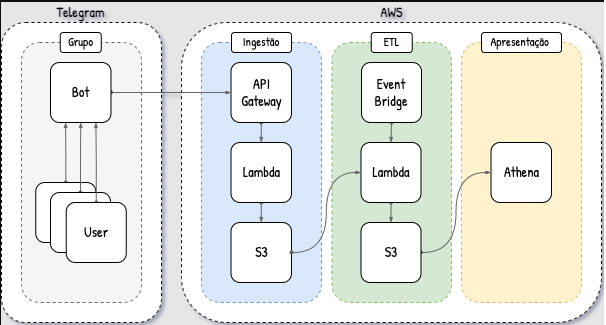

**Onde:**

*   **Telegram:**  é a fonte de dados transacionais, onde as mensagens enviadas por usuários do grupo são capturadas por um *bot* e redirecionadas via *webhook* do *backend* do aplicativo para um *endpoint* exposto pelo `AWS API Gateway`. As mensagens trafegam no corpo ou *payload* da requisição.

*   **AWS | Ingestão:** uma requisição HTTP com o conteúdo da mensagem em seu payload é recebia pelo ``AWS API Gateway`` que, por sua vez, redireciona-as para o ``AWS Lambda``, servindo assim como seu gatilho. Já o ``AWS Lambda`` recebe o payload da requisição em seu parâmetro event, salva o conteúdo em um arquivo no formato JSON (original, mesmo que o payload) e o armazena no ``AWS S3`` particionado por dia.

*   **AWS | ETL (processamento):** uma vez ao dia, o ``AWS Event Bridge`` aciona o ``AWS Lambda`` que processa todas as mensagens do dia anterior (atraso de um dia ou D-1), denormaliza o dado semi-estruturado típico de arquivos no formato JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet e o armazena no A``WS S3`` também particionado por dia.

*   **AWS | Apresentação (análise):** por fim, uma tabela do ``AWS Athena`` é apontada para o bucket do ``AWS S3`` que armazena os dados processados: denormalizado, particionado e orientado à coluna. Com isso, pode-se então executar as consultas analíticas por meio de consultas ``SQL`` para a obtenção de insights.

# 2. Estrutura Transacional: Telegram

A **estrutura transacional** é representada pelo **Telegram** que é a fonte *transacional* de dados do nosso *pipeline* de dados.


### 2.1 Criação do Bot e do Grupo

Para a elaboração dessa estrutura, cria-se um **grupo** e um **bot** e o adiciona ao grupo recém criado. Esse *bot*, então, captura **todas** as mensagens enviadas no grupo. As mensagens são acessadas através da API (*application programming interface*) de *bots* do **Telegram**.

O ``token`` de acesso à API HTTP é fornecido no momento da criação do bot.

A seguir é possível observar o **grupo** e o **bot** criados.

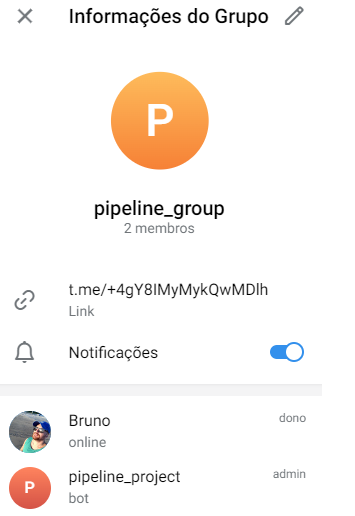

Notar que o **bot** é adicionado como administrador, pois assim poderá capturar as mensagens enviadas ao grupo.

Com a estrutura finalizada no **Telegram**, pode-se enviar mensagens ao **grupo** para iniciar o processo de coleta das mensagens.

### 2.4 Construção do Bot API

Nesse momento, insire-se o bot API dentro do código de programação que iniciará a coleta inicial dos dados e o preparo para a fase de ingestão dos dados dentro da estrutura analítica de nossa arquitetura.  

> **Nota:** A documentação completa da API do **Telegram** pode ser encontrada neste [link](https://core.telegram.org/bots/api)

Código:

In [ ]:
# Bibliotecas e pacotes utilizados.

from getpass import getpass

import json

import requests

In [ ]:
# Utilização do pacote getpass para acessar os dados das mensagens enviadas ao grupo com o token criado no Telegram.

token = getpass() #Aqui, usa-se o método getpass() a fim de manter a privacidade do token utilizado.

··········


In [ ]:
# Utilização dos pacotes json e requests para gerar as consultas e armazenar os dados.

base_url = f'https://api.telegram.org/bot{token}'   # A url base utilizada aqui é comum a todos os métodos de API do Telegram.

In [ ]:
# Aplicação do método getMe a fim de confirmar o token e e retornar informações sobre o bot.

response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

https://api.telegram.org/bot7658417291:AAE5dDOHHffm9rOIoplyZDxKNtPxqB_InPs/getMe
{
  "ok": true,
  "result": {
    "id": 7658417291,
    "is_bot": true,
    "first_name": "pipeline_project",
    "username": "m43_pipeline_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false,
    "can_connect_to_business": false,
    "has_main_web_app": false
  }
}


In [ ]:
# Retorno das mensagens captadas pelo bot com uso do método getUpdate.

response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 78240551,
      "message": {
        "message_id": 3,
        "from": {
          "id": 1504175167,
          "is_bot": false,
          "first_name": "Bruno",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1002272159709,
          "title": "pipeline_group",
          "type": "supergroup"
        },
        "date": 1728309410,
        "text": "HELLO, WORLD!"
      }
    },
    {
      "update_id": 78240552,
      "message": {
        "message_id": 4,
        "from": {
          "id": 1504175167,
          "is_bot": false,
          "first_name": "Bruno",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1002272159709,
          "title": "pipeline_group",
          "type": "supergroup"
        },
        "date": 1728309478,
        "text": "API testada com sucesso!"
      }
    },
    {
      "update_id": 78240553,
      "message": {
        "message_id": 5,
        "f

# 3.Estrutura Analítica: AWS

A **estrutura analítica** é representada pelo **AWS** que é a fonte *analítica* de dados do nosso *pipeline* de dados.

### 3.1 Mensagem

As mensagens enviadas no grupo e recuperadas via API é um dado do tipo semi-estruturado no formato JSON com algumas chaves mandatórias e diversas chaves opcionais.

Nesse projeto, foca-se em mensagens do tipo texto, ou seja, ingere-se as chaves mandatórias e a chave opcional `text`.

> **Nota**: A lista completa das chaves disponíveis pode ser encontrada na documentação neste [link](https://core.telegram.org/bots/api#message).

A seguir observa-se a amostra de uma mensagem com suas informações para melhor compreensão dos dados manipulados.

In [ ]:
# Criação de um arquivo em formato JSON para amostra.

%%writefile telegram.json
   {
      "update_id": 78240552,
      "message": {
        "message_id": 4,
        "from": {
          "id": 1504175167,
          "is_bot": false,
          "first_name": "Bruno",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1002272159709,
          "title": "pipeline_group",
          "type": "supergroup"
        },
        "date": 1728309478,
        "text": "API testada com sucesso!"
      }
    }

Writing telegram.json


Na sequência, a relação das variáveis analisadas.

| chave | tipo valor | opcional | descrição |
| -- | -- | -- | -- |
| updated_id | int | não | id da mensagem enviada ao **bot** |
| message_id | int | não | id da mensagem enviada ao grupo |
| from_id | int | sim | id do usuário que enviou a mensagem |
| from_is_bot | bool | sim | se o usuário que enviou a mensagem é um **bot** |
| from_first_name | str | sim | primeiro nome do usário que enviou a mensagem |
| chat_id | int | não | id do *chat* em que a mensagem foi enviada |
| chat_type | str | não | tipo do *chat*: private, group, supergroup ou channel |
| date | int | não | data de envio da mensagem no formato unix |
| text | str | sim | texto da mensagem |

### 3.2 Preparação dos Dados

Nessa fase preparatória, denormaliza-se o conteúdo da mensagem semi-estruturado no formato JSON apenas com uso de Python nativo, ou seja, sem o auxílio de pacotes, como Pandas.

Dessa forma, evita-se o risco de sobrecarregar a função *Lambda* no **AWS**.

In [ ]:
# Utilização do pacote json para carregar o arquivo "telegram.json".

import json

with open('telegram.json', mode='r', encoding='utf8') as fp:
  data = json.load(fp)
  data = data["message"]

In [ ]:
# com o método "json.dumps" retorna-se todo o conteúdo da mensagem.

print(json.dumps(data, indent=2))

{
  "message_id": 4,
  "from": {
    "id": 1504175167,
    "is_bot": false,
    "first_name": "Bruno",
    "language_code": "pt-br"
  },
  "chat": {
    "id": -1002272159709,
    "title": "pipeline_group",
    "type": "supergroup"
  },
  "date": 1728309478,
  "text": "API testada com sucesso!"
}


Utilização da estrutura de laços de repetição para varrer todas as chaves do arquivo e selecionar apenas as de interesse.

Caso a mensagem não possua a chave `text`, ela será criada com o valor igual a `None`.

Além disso, adiciona-se duas chaves de tempo para indicar o momento em que o dado foi processado: `context_date` e `context_timestamp`.

In [ ]:
from datetime import datetime

date = datetime.now().strftime('%Y-%m-%d')
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

parsed_data = dict()   #Arquivo denormalizado.

for key, value in data.items():

    if key == 'from':
        for k, v in data[key].items():
            if k in ['id', 'is_bot', 'first_name']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key == 'chat':
        for k, v in data[key].items():
            if k in ['id', 'type']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key in ['message_id', 'date', 'text']:
        parsed_data[key] = [value]

if not 'text' in parsed_data.keys():
  parsed_data['text'] = [None]

parsed_data['context_date'] = [date]
parsed_data['context_timestamp'] = [timestamp]

In [ ]:
#Retorno de amostra.

for k, v in parsed_data.items():
  print(f"{k}: {v}")

message_id: [4]
user_id: [1504175167]
user_is_bot: [False]
user_first_name: ['Bruno']
chat_id: [-1002272159709]
chat_type: ['supergroup']
date: [1728309478]
text: ['API testada com sucesso!']
context_date: ['2024-10-07']
context_timestamp: ['2024-10-07 20:26:22']


Por fim, utiliza-se o pacote Python PyArrow para criar uma tabela com os dados processados que são persistidos em um arquivo no formato Apache Parquet.

In [ ]:
import pyarrow as pa

table = pa.Table.from_pydict(mapping=parsed_data)

In [ ]:
# Retorno das informações gerais sobre o tipo dos dados da mensagen.

table

pyarrow.Table
message_id: int64
user_id: int64
user_is_bot: bool
user_first_name: string
chat_id: int64
chat_type: string
date: int64
text: string
context_date: string
context_timestamp: string
----
message_id: [[4]]
user_id: [[1504175167]]
user_is_bot: [[false]]
user_first_name: [["Bruno"]]
chat_id: [[-1002272159709]]
chat_type: [["supergroup"]]
date: [[1728309478]]
text: [["API testada com sucesso!"]]
context_date: [["2024-10-07"]]
context_timestamp: [["2024-10-07 20:26:22"]]

### 3.3 Ingestão

Nessa **primeira etapa** da **estrutura analítica**, ocorre a **ingestão** dos dados transacionais em ambientes analíticos. Esses dados são as mensagens capturadas pelo *bot*, que são ingeridas através da API *web* de *bots* do **Telegram**. Dessa forma, os dados são persistidos e fornecidos no formato JSON.

Em razão do **Telegram** reter mensagens por apenas 24h em seus servidores, a ingestão via **streaming** é a mais indicada.

Para tornar possível esse tipo de **ingestão**, utiliza-se como *webhook* o `AWS API Gateway`, que fará o redirecionamento do dado recebido para o `AWS Lambda`, que por sua vez, armazenará o dado em seu formato original (JSON) em um *bucket* do `AWS S3`.

Para colocar essa infra-estrutura em funcionamento, cria-se um *bucket* no `AWS S3`, uma função no `AWS Lambda`, uma API *web* no `AWS API Gateway`. Além disso, configura-se o *webhook* da API de bots no **Telegram**.

### 3.3.1 AWS S3

Inicialmente, um **data lake** é criado por meio de *bucket* no ``AWS S3`` para armazenamento dos dados brutos (*bucket* ``raw``).

Visualização:

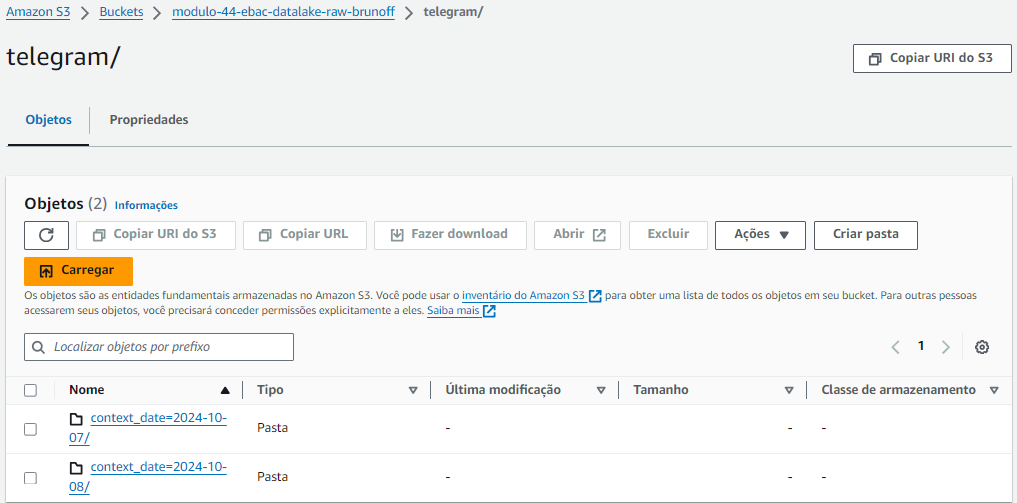

### 3.3.2 AWS LAMBDA

Após, cria-se uma função para persistir as mensagens captadas pelo *bot* do **Telegram** no *bucket* criado anteriormente.

Essa função opera da seguinte forma:

1. Recebe a mensagem no parâmetro `event`;

2. Verifica se a mensagem tem origem no grupo do **Telegram** correto;

3. Persiste a mensagem no formato JSON no *bucket* do `AWS S3`;

4. Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) à API de *bots* do **Telegram**.


Código da função:

In [ ]:
# Bibliotecas e pacotes utilizados.

import boto3
from datetime import datetime, timezone, timedelta
import json
import logging
import os


#Função utilizada dentro do AWS Lambda.

def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # Variáveis de ambiente.

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # Variáveis lógicas.

  tzinfo = timezone(offset=timedelta(hours=-3))  # Definição da timezone (Brasília).
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # Código principal

  client = boto3.client('s3')  # Variável que representa o S3.

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:  # Verifica se o id da mensagem é o mesmo do grupo (variável de ambiente).

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:   #Escreve a mensagem em arquivo tipo json.
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}') #Upload para bucket.

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

Para o correto funcionamento do código dentro do ``AWS Lambda`` ajusta-se algumas configurações:

1. As variáveis ambientais `AWS_S3_BUCKET` com o nome do *bucket* ``raw`` do `AWS S3` e `TELEGRAM_CHAT_ID` com o id do *chat* do grupo do **Telegram** são adicionadas dentro da função no `AWS Lambda`. Esse método de armazenar variáveis ambientais visa proteger informações sensíveis.

2. No `AWS IAM`, adiciona-se a permissão de escrita no *bucket* do `AWS S3` pela função do `AWS Lambda`.

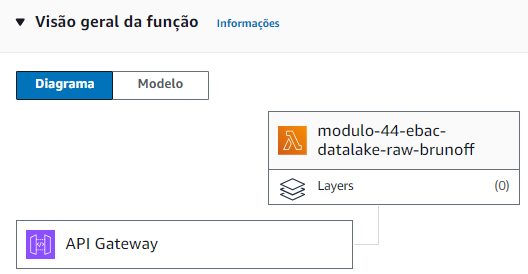

### 3.3.3 AWS API GATEWAY

Sequencialmente, o `AWS API Gateway`, através de uma API, recebe as mensagens captadas pelo *bot* do **Telegram**, que são enviadas via *webhook*.

Assim, inicia-se a função do `AWS Lambda`, que passa o conteúdo da mensagem no seu parâmetro *event*.

Após a criação da API, aplica-se o endereço ``url`` gerado na variável.

Visualização:

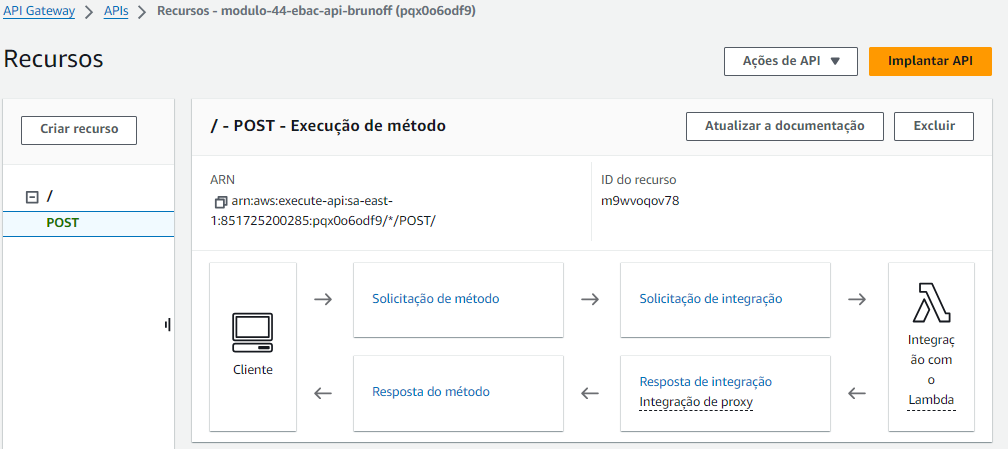

In [ ]:
# Aplicação do método getpas() para manter anonimato do endereço utilizado.

aws_api_gateway_url = getpass()

··········


### 3.3.4 Telegram

Por fim, configura-se o *webhook* para redirecionar as mensagens à `url` do `AWS API Gateway`.

Dessa forma, finaliza-se a criação da etapa de **ingestão** dos dados.

In [ ]:
# Aplicação do método "setWebhook" para configurar o redirecionamento das mensagens.

# A partir desse ponto, o método "getUpdates" permenece inativado.

response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


In [ ]:
# Aplicação do método "getWebhookInfo" retorna informações sobre o weebhook confugurado.

response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://pqx0o6odf9.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "last_error_date": 1728337313,
    "last_error_message": "Wrong response from the webhook: 500 Internal Server Error",
    "max_connections": 40,
    "ip_address": "52.67.115.62"
  }
}


### 3.4 ETL

Na **segunda etapa** da **estrutura analítica**, ocorre o processamento *analítico* dos dados, ou seja, é nessa etapa que os dados ingeridos oriundos de sistemas transacionais são extraídos, limpos, processados e carregados para então serem apresentados e analisados.  

Para isso, utiliza-se uma função do `AWS Lambda` como motor de processamento e um *bucket* do `AWS S3` como camada enriquecida para a persistência do dado processado . Para garantir a recorrência, configura-se uma regra do `AWS Event Bridge` como gatilho diáro da função.

### 3.4.1 AWS S3

Primeiramente, cria-se um *bucket* no ``AWS S3`` para armazenar passivamente as mensagens processadas de um dia em um único arquivo no formato Parquet.

A fim de garantir um padrão para todos os serviços dessa camada, adiciona-se o sufixo ``-enriched`` ao *bucket* criado.  

Visualização:

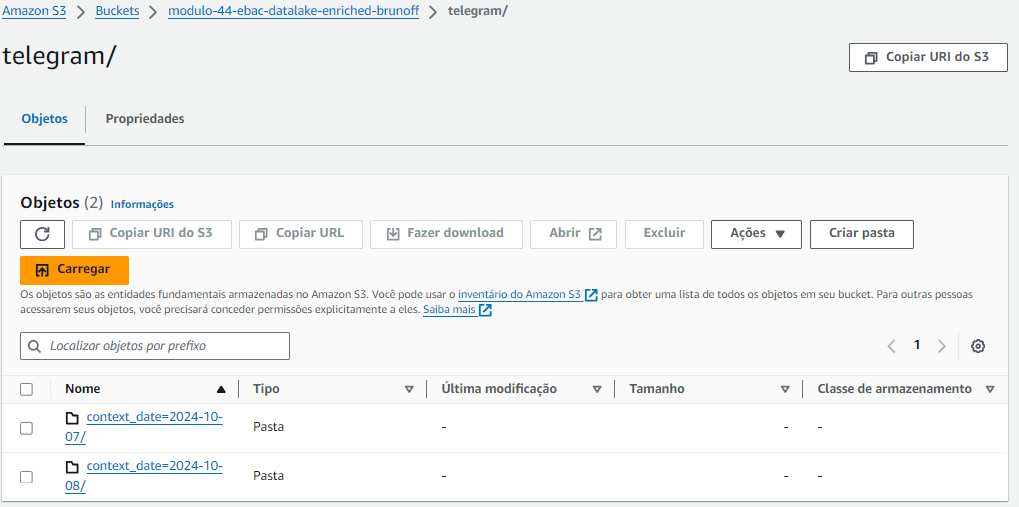

### 3.4.2 AWS LAMBDA

Após, o `AWS Lambda` atua por meio de sua função de ativamente processar as mensagens captadas pelo *bot* do **Telegram**, persistidas na camada cru (``raw``) no *bucket* do `AWS S3`, e persisti-las na camada enriquecida, também em um *bucket* do `AWS S3` (``enriched``).

A função criada opera da seguinte maneira:



- Lista todos os arquivos JSON de uma única participação da camada crua do *bucket* ``-raw`` do `AWS S3`;

- Então, para cada arquivo listado:

 - Faz o *download* do arquivo e carrega o conteúdo da mensagem;

 - Executa uma função de processamento dos dados (*data wrangling*);

 - Cria uma tabela do PyArrow e a contatena com as demais.

- Persiste a tabela no formato Parquet na camada enriquecida do *bucket* ``-enriched`` do `AWS S3`.

A seguir, o código utilizado na função *Lambda* criada.

In [ ]:
# Bibliotecas e pacotes utilizados.

import boto3
from datetime import datetime, timedelta, timezone
import json
import logging
import os
import pyarrow as pa
import pyarrow.parquet as pq

# Função utilizada dentro do AWS Lambda.

def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # Variáveis de ambiente.

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # Variáveis lógicas.

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d') # Notar utilização dos dados do dia anterior.
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # Código principal.

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}') # Download dos objetos.

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}") # Dia menos um, captura assim o dia anterior.

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data) # Criação de linha.

        if table:

          table = pa.concat_tables([table, iter_table])   # Se já houver tabela(s) irá concatenar.

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet') # Aplicação do conteúdo ao arquivo Parquet criado.
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet") # Upload para bucket -enriched no S3.

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

In [ ]:
# Utilizada da função 'parse_date' para o processamento dos dados (data wrangling).

def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Para o correto funcionamento do código dentro do ``AWS Lambda``, aqui também é necessário configurar alguns ajustes:



- **variáveis de ambiente**: adição das variáveis `AWS_S3_BUCKET` e `AWS_S3_ENRICHED` com os nomes dos *buckets* no `AWS S3` da camada ``-raw`` e da camada ``-enriched``, respectivamente.

- **permissão**: no ``AWS IAM`` adiciona-se a permissão de escrita nos *buckets* do `AWS S3` para a função do `AWS Lambda`.

- **recursos**: aumento do tempo de execução (*timeout*) da função no ``AWS Lambda`` para 5 minutos para lidar com o IO (*input/output*) de arquivos do `AWS S3`.

- **camadas**: criação de uma camada (*layer*) para aplicação do pacote Python PyArrow, que não é fornecido no ambiente padrão do ``AWS Lambda``, o que faz necessário o download do pacote, e conectar à função *Lambda*.

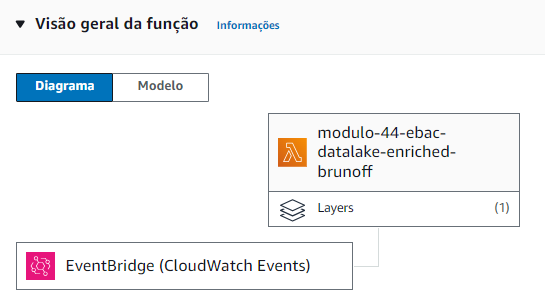

Visualização do pacote adicionado no AWS.

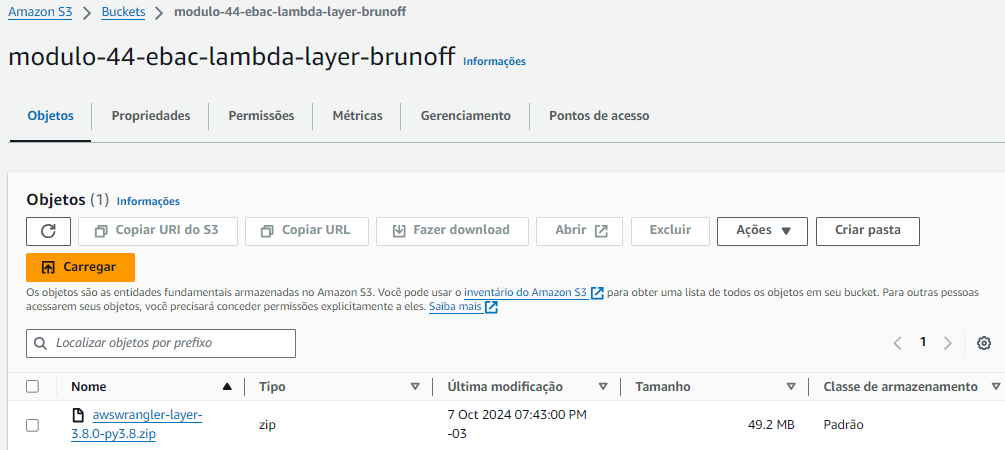

### 3.4.3 AWS EVENT BRIDGE

Por fim, configura-se o `AWS Event Bridge` que ativará diariamente a função de **ETL** (função de processamento dos dados) no `AWS Lambda`. Assim, atua como um *scheduler* da função.

Com isso, finaliza-se a **etapa** de **ETL**, ou seja, o processamento dos dados, para possibilitar a etapa de apresentação e análise dos dados.

Visualização:

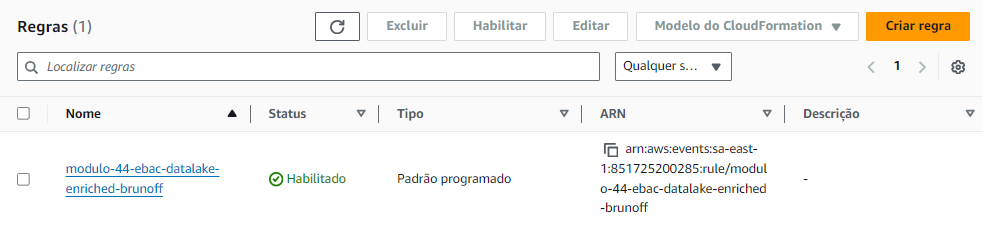

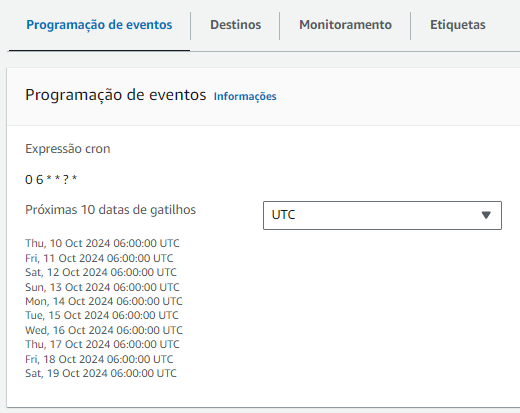

### 3.5 Apresentação

Na terceira e última etapa da **estrutura analítica**, chega-se na **etapa** da **apresentação** dos dados no ``AWS Athena``. Aqui, os dados são apresentados de forma específica após consultas (*query*) geradas por comandos em ``SQL``, que fornecem as mais variadas informações a fim de gerar respostas para as diversas perguntas de negócio, o que corresponde a análise dos dados propriamente dita.   

As consultas realizadas nessa etapa atendem a demanda por respostas sobre questões de negócio pertinentes a um ``SAC`` (*serviço de atendimento ao consumidor*) automatizado.



Criação da Tabela

**Query:**



```
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://modulo-44-ebac-datalake-enriched-brunoff/telegram/'
```



Amostra de consulta

**Query:**



```
SELECT * FROM `telegram` LIMIT 10;
```

**Resultado:**


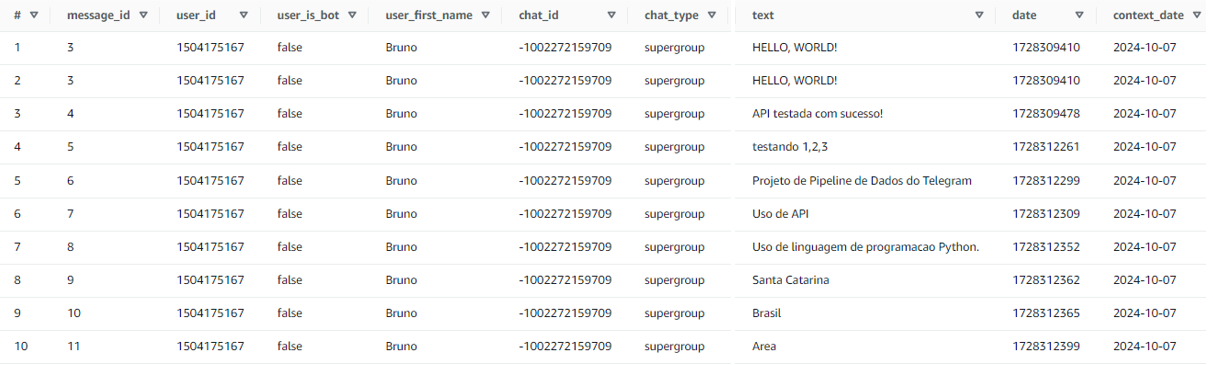

Quantidade de mensagens por dia

**Query:**



```
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

**Resultado:**


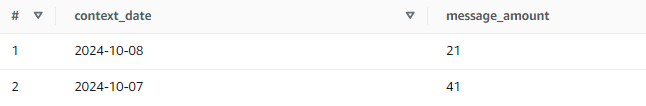

**Insight**: por meio dessa métrica é possível verificar se de fato o grupo é utilizado e a quantidade de mensagens, o que pode indicar a efetividade do uso.

Quantidade de mensagens por usuário por dia

**Query:**



```
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

**Resultado:**


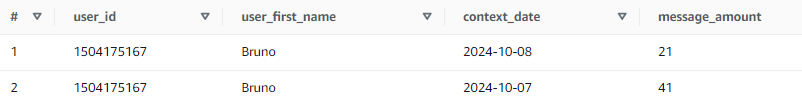

**Insight**: com essa métrica é possível observar quais usuários utilizam o grupo, quais usuários são mais atuantes e a quantidade de mensagens. A partir dessa informação, pode-se estabelecer também normas e diretrizes de conduta no atendimento ao cliente ao considerar as demandas que motivam o contato.

**NOTA**: por utilizar dados de simulação, a amostra de informação visa demonstrar a funcionalidade do pipeline construído.

Média do tamanho das mensagens por usuário por dia

**Query:**



```
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

**Resultado:**


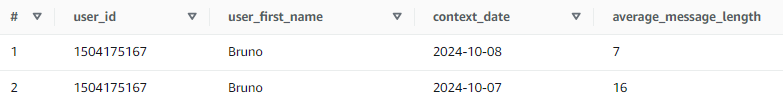

**Insight**: quanto maiores as mensagens, mais significativas elas tendem a ser, pois um relato de uma situação exige uso de quantidade de palavras maiores. Essa métrica pode ajudar a estabelecer a detectar a frequência de casos de insastifação, por exemplo.

Quantidade de mensagens por hora por dia da semana por número da semana

**Query:**



```
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

**Resultado:**

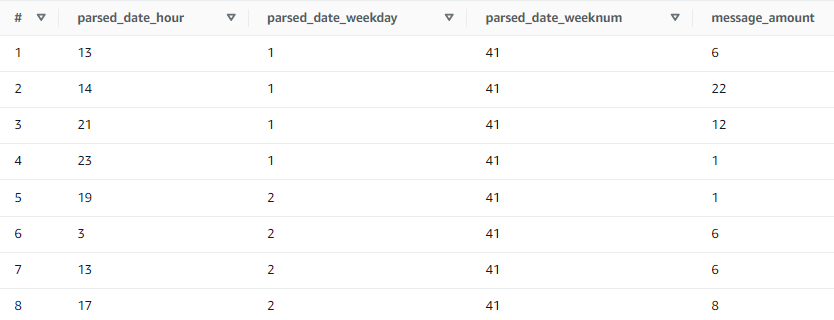

**Insight**: aqui verificamos a quantidade de mensagens por hora e por dia da semana. Essa informação é vital para ajustar canais de atendimento aos horários de maior utilização e, assim, otimizar recursos financeiros e humanos na resolução das demandas, já que o ``SAC`` automatizado é a primeira etapa de atendimento ao consumidor.

Adição de partições disponíveis

Quando uma nova partição é adicionada ao repositório de dados, é necessário informar o `AWS Athena` para que a ela esteja disponível via ``SQL``. Para isso, utiliza-se o comando ``SQL`` `MSCK REPAIR TABLE <nome-tabela>` para todas as partições (mais caro) ou `ALTER TABLE <nome-tabela> ADD PARTITION <coluna-partição> = <valor-partição>` para uma única partição (mais barato).

**Query:**



```
MSCK REPAIR TABLE `telegram`;
```



# 4. Visualização Gráfica dos Dados

A partir da finalização da passagem dos dados através de toda a *arquitetura* estruturada, é possível gerar *representações gráficas* das **análises** mais significativas para o negócio por meio de um ``Dashboard`` interativo.

A visualização gráfica completa dos dados alimentados pelo *pipeline* na nuvem pode se explorada no ``Dashboard`` disponível na Plataforma **Looker Studio** nesse [link](https://lookerstudio.google.com/reporting/5e7afa95-3626-4e18-9a7f-29eb8db3fae2/page/1KtEE).

A seguir uma amostra da visualização geral do ``Dashboard``.

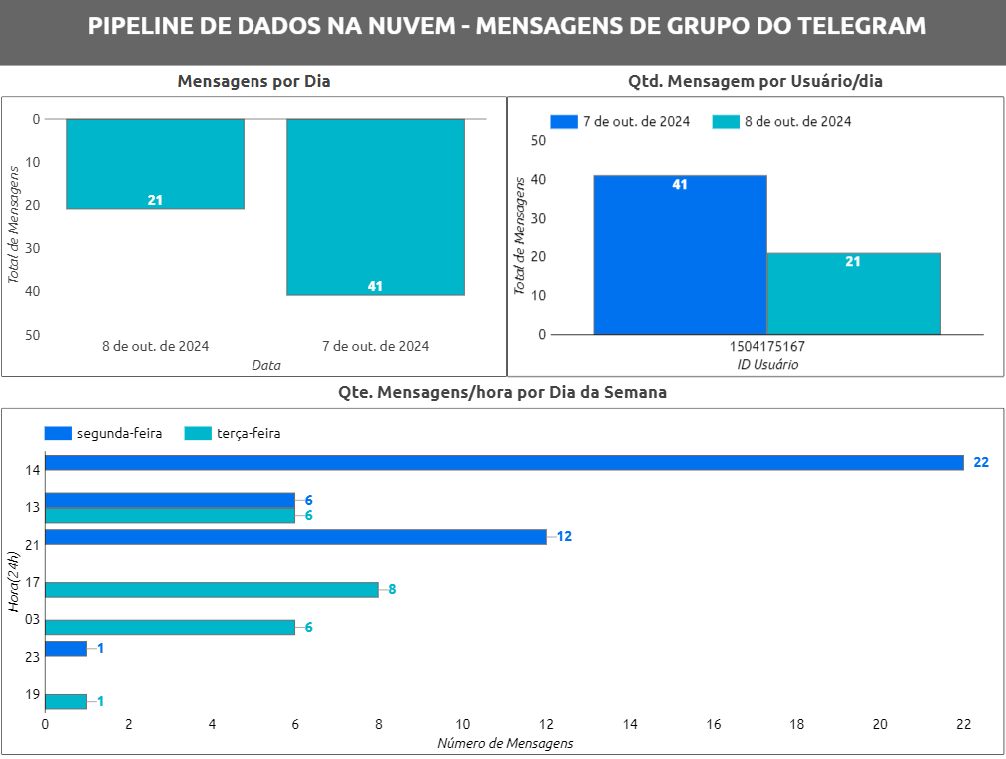

# 5. Considerações Finais

A realização desse projeto permite constatar que uma grande estrutura de manipulação dos dados, desde sua coleta até a apresentação gráfica, requer conhecimento e práticas específicas que não são percebidas por usuários em geral.

Apesar de se tratar de simulação para fins de testagem, pode-se determinar com exatidão métricas valiosas, como os dias e os horários de envio das mensagens, quantidade de mensagens por dia e também por usuário. Isso atesta a efetividade de uso do grupo no Telegram e que é possível gerar parâmetros que norteiam as estratégias de infra-estrutura de atendimento, marketing, venda e relacionamento com os clientes de forma mais precisa, efetiva e rentável.

